# Time Series Analysis

In [1]:
# 1️⃣ Import Libraries
# Install statsmodels (if not installed)
!pip install statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score



In [2]:
from google.colab import files

uploaded = files.upload()


Saving final_store_train_data.csv to final_store_train_data.csv


In [3]:
train = pd.read_csv("final_store_train_data.csv")

train['Date'] = pd.to_datetime(train['Date'])
train = train.sort_values('Date')

train.head()


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017208,1115,d,c,5350.0,8.0,2010.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2,2013-01-01,0.0,0,0,0,a,1
679363,746,d,c,4330.0,2.0,2011.0,1,35.0,2011.0,"Mar,Jun,Sept,Dec",2,2013-01-01,0.0,0,0,0,a,1
155193,171,a,a,2640.0,8.0,2010.0,0,22.0,2012.0,NaN,2,2013-01-01,0.0,0,0,0,a,1
632403,694,a,c,460.0,11.0,2012.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",2,2013-01-01,0.0,0,0,0,a,1
361623,396,a,c,23130.0,8.0,2010.0,0,22.0,2012.0,NaN,2,2013-01-01,0.0,0,0,0,a,1


In [4]:
daily_sales = train.groupby('Date')['Sales'].sum()

print(daily_sales.head())


Date
2013-01-01      94017.5
2013-01-02    6889055.5
2013-01-03    6311098.5
2013-01-04    6604305.0
2013-01-05    5908448.0
Name: Sales, dtype: float64


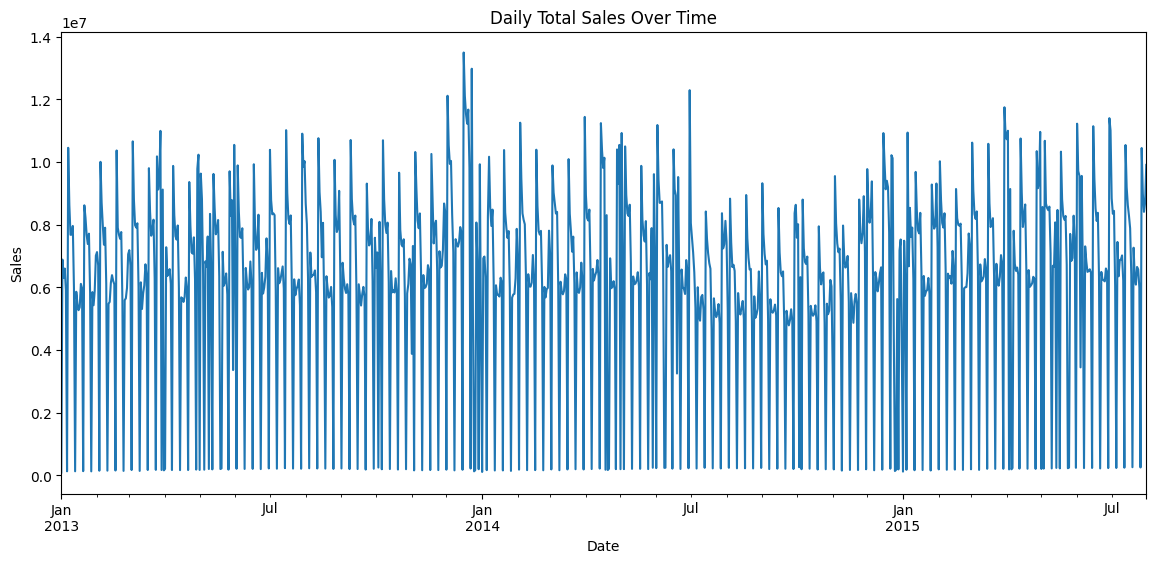

In [5]:
plt.figure(figsize=(14,6))
daily_sales.plot()
plt.title("Daily Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


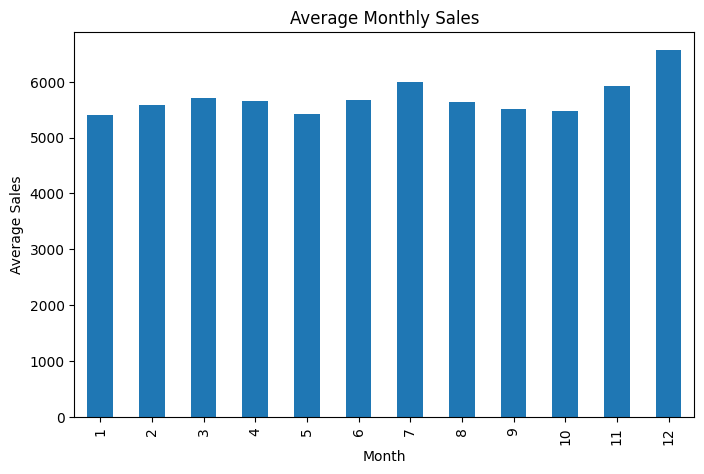

In [6]:
train['Month'] = train['Date'].dt.month
monthly_sales = train.groupby('Month')['Sales'].mean()

plt.figure(figsize=(8,5))
monthly_sales.plot(kind='bar')
plt.title("Average Monthly Sales")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.show()


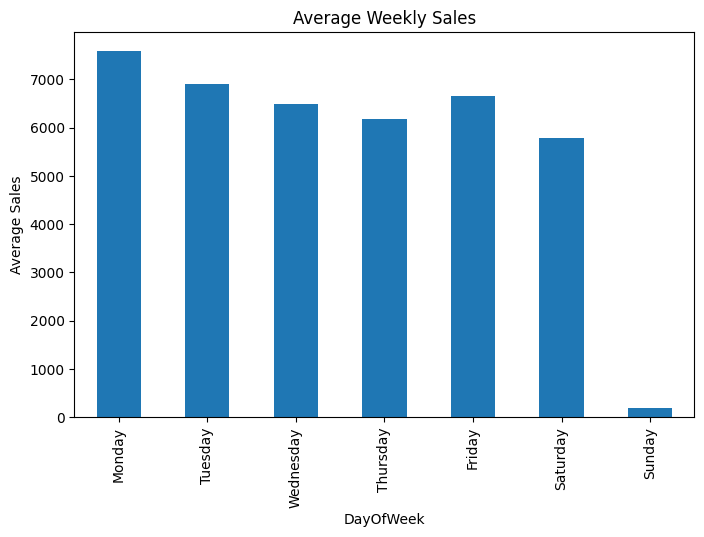

In [7]:
train['DayOfWeek'] = train['Date'].dt.day_name()
weekly_sales = train.groupby('DayOfWeek')['Sales'].mean()

weekly_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

plt.figure(figsize=(8,5))
weekly_sales.loc[weekly_order].plot(kind='bar')
plt.title("Average Weekly Sales")
plt.ylabel("Average Sales")
plt.show()


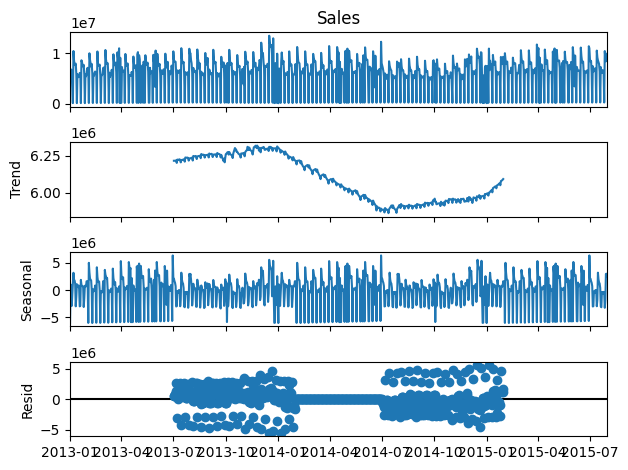

In [8]:
decomposition = seasonal_decompose(daily_sales, model='additive', period=365)

decomposition.plot()
plt.show()


In [9]:
result = adfuller(daily_sales)

print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("Series is Stationary")
else:
    print("Series is NOT Stationary")


ADF Statistic: -4.680473879416896
p-value: 9.155499532186385e-05
Series is Stationary


In [10]:
daily_sales_diff = daily_sales.diff().dropna()

result_diff = adfuller(daily_sales_diff)

print("After Differencing p-value:", result_diff[1])


After Differencing p-value: 1.775961416957708e-26


<Figure size 1200x400 with 0 Axes>

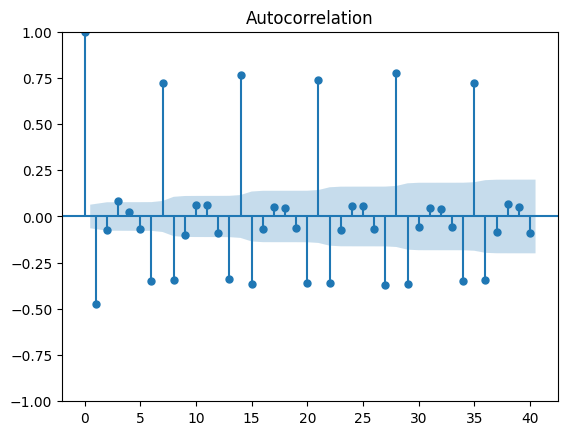

<Figure size 1200x400 with 0 Axes>

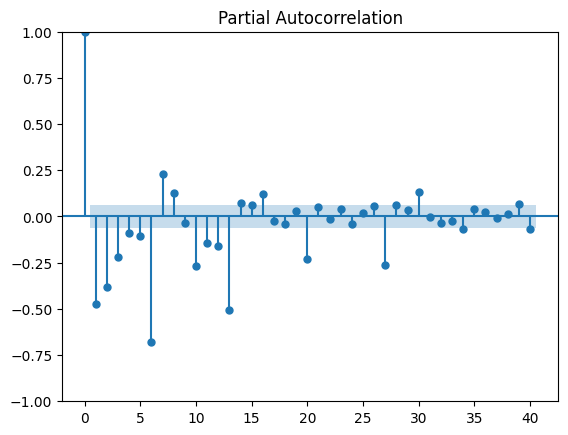

In [11]:
plt.figure(figsize=(12,4))
plot_acf(daily_sales_diff, lags=40)
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(daily_sales_diff, lags=40)
plt.show()


In [12]:


model = SARIMAX(daily_sales,
                order=(1,1,1),
                seasonal_order=(1,1,1,7))  # Weekly seasonality

model_fit = model.fit()

print(model_fit.summary())



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  942
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -14912.557
Date:                           Sun, 15 Feb 2026   AIC                          29835.114
Time:                                   21:30:51   BIC                          29859.311
Sample:                               01-01-2013   HQIC                         29844.341
                                    - 07-31-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2001      0.061      3.285      0.001       0.081       0.319
ma.L1         -0.9301      0.044    -21.136

In [13]:
#In-Sample Training Prediction
train_pred = model_fit.predict(
    start=daily_sales.index[0],
    end=daily_sales.index[-1]
)

print(train_pred.head())

2013-01-01    0.000000e+00
2013-01-02    5.660777e+04
2013-01-03    3.395673e+06
2013-01-04    3.957267e+06
2013-01-05    4.594632e+06
Freq: D, Name: predicted_mean, dtype: float64


In [14]:
# Training Accuracy
rmse = np.sqrt(mean_squared_error(daily_sales, train_pred))
r2 = r2_score(daily_sales, train_pred)

print("Training RMSE:", round(rmse, 2))
print("Training R2 Score:", round(r2, 4))


Training RMSE: 1781174.17
Training R2 Score: 0.659


In [15]:
#Forecast Next 42 Days (6 Weeks)
forecast_steps = 42

forecast_result = model_fit.get_forecast(steps=forecast_steps)

forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()


In [16]:
#Create Forecast DataFrame
forecast_index = pd.date_range(
    start=daily_sales.index[-1] + pd.Timedelta(days=1),
    periods=forecast_steps,
    freq='D'
)

forecast_df = pd.DataFrame({
    "Date": forecast_index,
    "Forecasted_Sales": forecast_mean.values,
    "Lower_Bound": forecast_ci.iloc[:, 0].values,
    "Upper_Bound": forecast_ci.iloc[:, 1].values
})

print("6 Week Forecast")
print(forecast_df.head())


6 Week Forecast
        Date  Forecasted_Sales   Lower_Bound   Upper_Bound
0 2015-08-01      7.605175e+06  2.083705e+06  1.312665e+07
1 2015-08-02      8.659146e+05 -4.853267e+06  6.585096e+06
2 2015-08-03      8.472106e+06  2.712128e+06  1.423208e+07
3 2015-08-04      8.204065e+06  2.420392e+06  1.398774e+07
4 2015-08-05      7.805696e+06  2.001243e+06  1.361015e+07


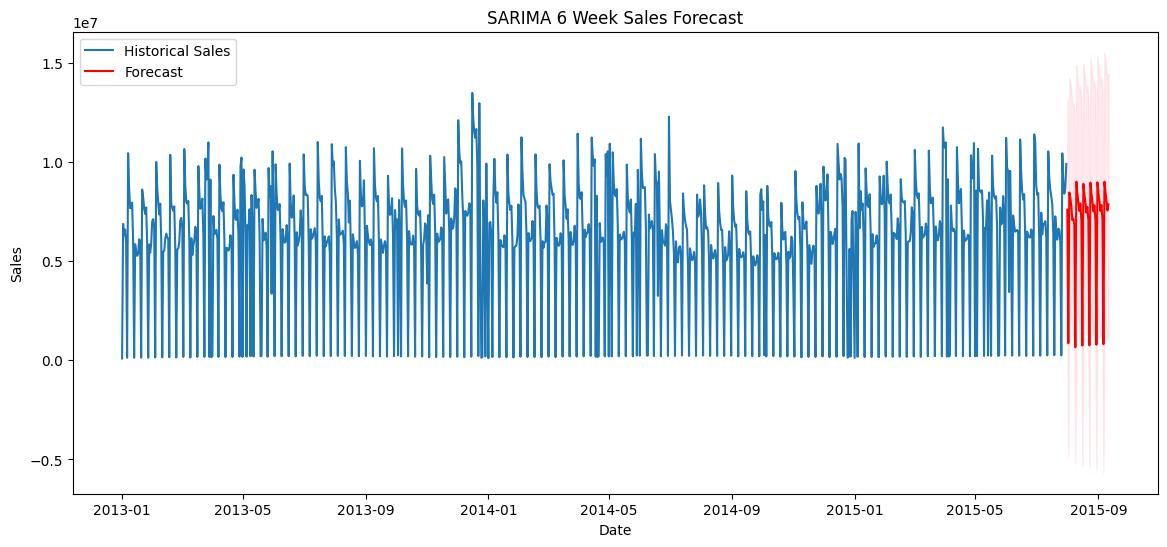

In [17]:
# Plot Historical,Forecast & Confidence Interval
plt.figure(figsize=(14,6))

plt.plot(daily_sales, label="Historical Sales")
plt.plot(forecast_index, forecast_mean, color="red", label="Forecast")

plt.fill_between(
    forecast_index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color="pink",
    alpha=0.3
)

plt.title("SARIMA 6 Week Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


In [18]:
# Save Forecast to CSV
forecast_df.to_csv("sarima_6_week_forecast.csv", index=False)

print("Forecast saved successfully!")

Forecast saved successfully!
